# AUPIMO Score of a Random Model

If model randomly assigns scores to the pixels -- i.e. no discrimination -- its AUROC score will be 50%. 

What would be its AUPIMO score?

> AUPIMO is pronounced "a-u-pee-mo".

> For basic usage, please check the notebook [701a_aupimo.ipynb](./701a_aupimo.ipynb).

> For PIMO curve plots, please check the notebook [701c_aupimo_advanced_ii.ipynb](./701c_aupimo_advanced_ii.ipynb).


# What is AUPIMO?

The `Area Under the Per-Image Overlap [curve]` (AUPIMO) is a metric of recall (higher is better) designed for visual anomaly detection.

Inspired by the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [PRO](https://link.springer.com/article/10.1007/s11263-020-01400-4) curves, 

> AUPIMO is the area under a curve of True Positive Rate (TPR or _recall_) as a function of False Positive Rate (FPR) restricted to a fixed range. 

But:
- the TPR (Y-axis) is *per-image* (1 image = 1 curve/score);
- the FPR (X-axis) considers the (average of) **normal** images only; 
- the FPR (X-axis) is in log scale and its range is [1e-5, 1e-4]\* (harder detection task!).

\* The score (the area under the curve) is normalized to be in [0, 1].

AUPIMO can be interpreted as

> average segmentation recall in an image given that the model (nearly) does not yield false positives in normal images.

References in the last cell.

![AUROC vs. AUPRO vs. AUPIMO](./roc_pro_pimo.svg)

# Setup

Install `anomalib` using `pip`.

In [ ]:
# TODO(jpcbertoldo): replace by `pip install anomalib` when AUPIMO is released  # noqa: TD003
%pip install ../..

Imports

In [7]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import FixedLocator, PercentFormatter
from numpy import ndarray

In [3]:
%matplotlib inline

# Random Model

If a model cannot discriminate between normal and anomalous images, the survival fuctions\* of the anomaly scores conditioned to each class would be the same.

> \* https://en.wikipedia.org/wiki/Survival_function

In other words, FPR and TPR would be the same.

Let's simulate this situation.

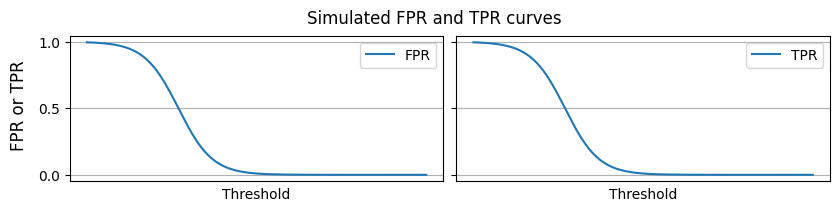

In [4]:
thresholds = torch.linspace(0, 1, 1001)

# fpr and tpr as a function of the threshold (i.e. the survival functions)
# generaly look like logistic functions flipped horizontally
# their actual shapes don't matter much, but rather how they compare to each other
# in this case, since they're the same, this choice is arbitrary as long as
# they're monotonically decreasing with the threshold
fpr = 1 - 1e2 / (1e2 + torch.exp(-20 * (thresholds - 0.5)))
tpr = fpr.clone()

fig, axes = plt.subplots(1, 2, figsize=(8, 2), constrained_layout=True, sharey=True)

axes[0].plot(thresholds, fpr, label="FPR")
axes[1].plot(thresholds, tpr, label="TPR")

for ax in axes:
    ax.set_xlabel("Threshold")
    ax.legend(loc="upper right")
    ax.set_yticks([0, 0.5, 1])
    ax.set_xticks([])
    ax.grid()

fig.supylabel("FPR or TPR", x=-0.03)
fig.suptitle("Simulated FPR and TPR curves")
fig  # noqa: B018, RUF100

# PIMO curve

In the ROC curve, the FPR = TPR looks like a straight line.

What does it look like in the PIMO curve?

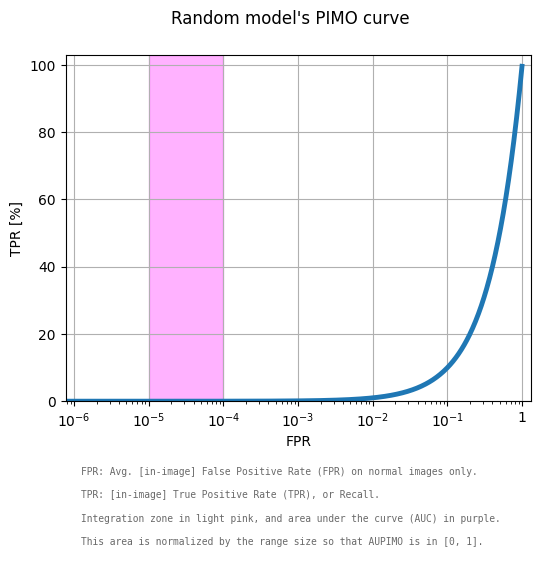

In [5]:
# utility plot functions (from the previous notebook)


def fmt_pow10(value: float) -> str:
    """Format the power of 10."""
    return "1" if value == 1 else f"$10^{{{int(np.log10(value))}}}$"


def plot_pimo_with_auc_zone(
    ax: Axes,
    tpr: ndarray,
    fpr: ndarray,
    lower_bound: float,
    upper_bound: float,
    fpr_in_auc: ndarray,
    tpr_in_auc: ndarray,
) -> None:
    """Helper function to plot the PIMO curve with the AUC zone."""
    # plot
    ax.plot(fpr, tpr, linewidth=3.5)
    ax.axvspan(lower_bound, upper_bound, color="magenta", alpha=0.3, zorder=-1)
    ax.fill_between(fpr_in_auc, tpr_in_auc, alpha=1, color="tab:purple", zorder=1)

    # config plots
    ax.set_ylabel("TPR [%]")
    ax.yaxis.set_major_locator(FixedLocator(np.linspace(0, 1, 6)))
    ax.yaxis.set_major_formatter(PercentFormatter(1, 0, symbol=""))
    ax.set_ylim(0, 1 + 3e-2)
    ax.set_xlabel("FPR")
    ax.set_xscale("log")
    ax.xaxis.set_major_locator(FixedLocator(np.logspace(-6, 0, 7)))
    ax.xaxis.set_major_formatter(lambda x, _: fmt_pow10(x))
    ax.set_xlim(1e-6 / (eps := (1 + 3e-1)), 1 * eps)
    ax.grid()


# simulate a random model's curve
lower_bound, upper_bound = 1e-5, 1e-4
threshs_auc_mask = (fpr > lower_bound) & (fpr < upper_bound)
fpr_in_auc = fpr[threshs_auc_mask]
tpr_in_auc = tpr[threshs_auc_mask]

fig, ax = plt.subplots(figsize=(6, 4.5))
plot_pimo_with_auc_zone(ax, tpr, fpr, lower_bound, upper_bound, fpr_in_auc, tpr_in_auc)

fig.text(
    0.15,
    -0.01,
    """
FPR: Avg. [in-image] False Positive Rate (FPR) on normal images only.

TPR: [in-image] True Positive Rate (TPR), or Recall.

Integration zone in light pink, and area under the curve (AUC) in purple.

This area is normalized by the range size so that AUPIMO is in [0, 1].
""",
    ha="left",
    va="top",
    fontsize="x-small",
    color="dimgray",
    font="monospace",
)

fig.suptitle("Random model's PIMO curve")
fig  # noqa: B018, RUF100

# AUPIMO Score

Recall that AUPIMO is computed from this integral:

$$
    \frac{1}{\log(U/L)}
    \int_{\log(L)}^{\log(U)} 
    \operatorname{TPR}^{i}\left( \operatorname{FRP^{-1}}( z ) \right)
    \, 
    \mathrm{d}\log(z)   
$$

where the integration bounds -- $L$[ower] and $U$[pper] -- are the FPR bounds.

By assuming $\operatorname{TPR}^{i} = \operatorname{FPR}$, the AUPIMO score only depends on the FPR bounds:

$$
    \text{AUPIMO of a random model} = \frac{U - L}{\log(U/L)}
$$

In [6]:
def random_model_aupimo(lower_bound: float, upper_bound: float) -> float:
    """AUPIMO score obtained by a random model (no class discrimination)."""
    return (upper_bound - lower_bound) / np.log(upper_bound / lower_bound)


print(f"{random_model_aupimo(1e-4, 1e-5)=:.3%}")

random_model_aupimo(1e-4, 1e-5)=0.004%


Notice how a random model's AUPIMO score of $0.004%$ is numerically neglegible in the scale up to 100% -- while its AUROC is 50%.

It's easier to interpret the meaning of AUPIMO scores: 
- $0$%: random or worse, 
- $100$%: perfect.

# Cite Us

AUPIMO was developed during [Google Summer of Code 2023 (GSoC 2023)](https://summerofcode.withgoogle.com/archive/2023/projects/SPMopugd) with the `anomalib` team from Intel's OpenVINO Toolkit.

arXiv: [arxiv.org/abs/2401.01984](https://arxiv.org/abs/2401.01984) (accepted to BMVC 2024)

Official repository: [github.com/jpcbertoldo/aupimo](https://github.com/jpcbertoldo/aupimo) (numpy-only API and numba-accelerated versions available)

```bibtex
@misc{bertoldo2024aupimo,
      author={Joao P. C. Bertoldo and Dick Ameln and Ashwin Vaidya and Samet Akçay},
      title={{AUPIMO: Redefining Visual Anomaly Detection Benchmarks with High Speed and Low Tolerance}}, 
      year={2024},
      url={https://arxiv.org/abs/2401.01984}, 
}
```